
# EP2 de Programacao Paralela e Distribuída - MAC5742



| Nome | N° USP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | 9793401 |


## Resumo

A ideia deste trabalho é continuar os estudos iniciados no [EP1](https://github.com/aserranoni/parallel-mandelbrot).
Mais uma vez, implementaremos duas versões de um algorítmo que gera imagens do conjunto de Mandelbrot; a primeira delas utilizando OpenMPI e a segunda com o auxílio de um acelerador (GPU), utilizando CUDA. Além disso, vamos realizar experimentos e analisar o desempenho de cada programa afim de estudar brevemente o comportamento de cada implementação. Os arquivos utilizados para a produção deste estudo encontram-se disponíveis [neste repositório](https://github.com/martinoni/parallel-ep2).

## Implementações em C

Como mencionado acima temos dois programas, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente.  Como novamente utilizamos o `mandelbrot_seq.c` como base para as implementações `mandelbrot_ompi.c` e `mandelbrot_cuda.cu`,  vamos mais uma vez comentar algumas das mudanças que fizemos na implementação do primeiro antes de continuarmos: 

#### Percorrendo vetores multidimensionais com um único laço

Em primeiro lugar, é importante reconhecer que a divisão do trabalho de um algorítmo em unidades tão pequenas quanto possível nos oferece uma flexibilidade maior ao alocar tarefas para cada thread ou processo.

Na implementação original que recebemos como base, a função `compute_mandelbrot()` operava com dois laços. Neste contexto,
cada iteração do laço externo era responsável por uma linha da imagem. Portanto, para dividir o trabalho da função em unidades menores do que uma linha, seríamos obrigados a criar threads dentro de threads ou então partir para um novo 
paradigma de implementação do nosso programa. 

Na versão implementada com OpenMPI, consideramos dois parâmetros `i_x_thread` e `i_y_thread`, desta vez percorrendo todos os `image_buffer_size` pixels da imagem. Sabendo o número `image_size` de pixels em cada linha, conseguimos descobrir a linha (`taskid/image_size`) e coluna (`taskid%image_size`) exatas de um pixel a partir do parâmetro `taskid`, que representa a identificação do processo a ser chamado. É importante que avisemos que, devido à falta de disponibilidade de máquinas com OpenMPI configurado, todos os processos MPI foram abertos no mesmo computador. Por este motivo, não conseguiremos  testar a capacidade real da biblioteca neste projeto, já que a ideia é que o trabalho seja dividido em um  número 
$N>1$ de máquinas.

Já na versão CUDA, utilizamos dois parâmetros para a execução do programa: `blockDim` e `gridDim`, que representam as dimensões (x, y) dos blocos (organização das threads dentro dos blocos - determina quantas threads existe em cada bloco) e das grids (organização dos blocos na grid - determina quantos blocos existe na grid), respectivamente. Desta forma, conseguimos determinar as coordenadas (i_x, i_y) dos pixels em que cada thread trabalhará calculando `i_x=blockIdx.x*blockDim.x + threadIdx.x` e `i_y=blockIdx.y*blockDim.y + threadIdx.y`.

Em ambas as versões que programamos, quando um processo ou thread acaba sua primeira tarefa, checa se todos os píxels da imagem já foram incluídos na lista de tarefas, e se não, ganha um novo valor e trabalha em cima do novo píxel. Desta forma, conseguimos abranger toda a imagem que será gerada independentemente do tamanho da mesma e sem nos preocuparmos com a divisibilidade de seu tamanho pelo número de threads/processos.

#### Cálculos de tempo e implicações de latência

Neste trabalho estamos reutilizando toda a estrutura para medição de tempo feita no `EP1`. 
Vale ressaltar que iremos medir o tempo de execução dos programas desde seu início do até o término, incluindo o tempo de alocação de memória e da escrita do arquivo no disco.

A razão para isso é que aumentar o número de threads e processos paralelos não nesessariamente implica numa diminuição do tempo de execução do programa. Isso acontece porque, no caso do MPI, não podemos desprezar o tempo que as trocas de mensagens entre os processos consomem. Similarmente, na versão CUDA o tempo de troca de informação da CPU (host) com o acelerador (device) deve ser levado em consideração. Além disso, em ambos as implementaçõestemos o tempo de alocação de memória, seja dentro de cada processo (MPI) ou dentro da GPU (CUDA).


## Máquina utilizada
A execução dos programas neste projeto foi feita na máquina `neozil`, da Rede Linux do IME. O computador suporta o CUDA Toolkit 9.1 e está equipado com duas GPUs Nvidia Tesla K20c SM35. Tais informações foram retiradas [deste site](https://linux.ime.usp.br/wiki/doku.php?id=faq:cuda).

## Infra estrutura Python

Para este relatório, utilizamos Jupyter notebooks e Python na versão 3.7.3. Tal escolha se deve à nossa maior familiaridade com
a linguagem e também à quantidade de material de apoio disponível online. Apesar disso, aproveitamos muitas das ideias dos trabalhos anteriores para implementar uma série de funções que foram feitas em Julia anteriormente. A seguinte célula fará as importações necessárias dos pacotes Python:  

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn

KeyboardInterrupt: 

## Experimentos e Coleta de Dados 

Mais uma vez, para que tenhamos dados para serem analisados, precisamos executar chamadas das nossas implementações em C
e armazenar seus resultados. A seguir, vamos descrever cada argumento da função `mandelbrot()`, que irá nos auxiliar nesta tarefa: 

O primeiro argumento `method` é uma string que determina qual das implementações
em C deve ser chamada. Os valores possíveis para esta variável são `"cuda"`, e `"mpi"`. 

O segundo argumento `n_mpi` representa o número de processos abertos no programa que utiliza OpenMPI.

O terceiro argumento `x_grid` para a versão em CUDA representa a coordenada x da organização de blocos dentro da grid.

O quarto argumento `y_grid` para a versão em CUDA representa a coordenada y da organização de blocos dentro da grid.

O quinto argumento `x_block` para a versão em CUDA representa a coordenada x da organização de threads dentro de cada bloco.

O sexto argumento `y_block` para a versão em CUDA representa a coordenada y da organização de threads dentro de cada bloco.

Antes de executarmos os programas em C, vamos compilá-los ao executar a seguinte célula:

In [2]:
!make

make: Nothing to be done for 'all'.


In [3]:
def mandelbrot(method, n_mpi=None, x_grid=None, y_grid=None, x_block=None, y_block=None):
    if method == "cuda":
        command = '%d %d %d %d' % (x_grid, y_grid, x_block, y_block)
        output = !./mandelbrot_cuda {command}
        output = output[0].split(', ')
    elif method == 'mpi':
        command = '--quiet --host localhost:%d mandelbrot_ompi' % (n_mpi)
        output = !mpirun {command}
        output = output[1].split(', ')
        
    infos = {'method': method, 
             'duration_clock': output[0],
             'duration_mono': output[1],
             'duration_sys': output[2],
             'n_mpi_process':n_mpi, 
             'x_grid_cuda':x_grid, 'y_grid_cuda': y_grid, 
             'x_block_cuda': x_block, 'y_block_cuda':y_block,
            'interaction': None}
    return infos


A função `run_experiments()`, que estamos utilizando desde o miniEP3, nos permite variar todos os parâmetros das chamadas feitas pela função `mandelbrot()` e estabelecer um número de repetições através do através do argumento `repetitions`.
Além disso, resultados são coletados e retornados na forma de um `DataFrame`. A função também recebe outros argumentos que devem estar na forma de lista que vão indicar quais parâmetros serão usados na execução dos programas.


In [4]:
def run_experiments(methods, n_mpis=None, grids=None, blocks=None, repetitions=15):
    !make
    results = []
    for method in methods:
        if method == 'mpi':
            print('Running mandelbrot_mpi:')
            for n_mpi in n_mpis:
                print('n_processes: %d' %  (n_mpi))
                for i in tqdm(range(repetitions)):
                    result = mandelbrot(method, n_mpi)
                    result['interaction'] = i+1
                    results.append(result)
        elif method == 'cuda':
            print('Running mandelbrot_cuda')
            for grid in grids:
                for block in blocks:
                    if grid != (1,1) or block != (1,1):
                        print('Grid_dim: (%d, %d) and Block_dim: (%d, %d)' %  (grid[0], grid[1], block[0], block[1]))
                        for i in tqdm(range(repetitions)):
                            result = mandelbrot(method, 
                                               x_grid=grid[0], y_grid=grid[1],
                                               x_block=block[0], y_block=block[1])
                            result['interaction'] = i+1
                            results.append(result)

    return results
    

Antes de iniciar os experimentos, vamos ajustar parâmetros da função `run_experiments()` conforme a tabela abaixo.
É importante alertar que a execução pode ser demorada (3h+). Por este motivo, optamos por deixar a linha responsável pela execução do experimento comentada.


|               	   | OpenMPI              | CUDA              	                | 
|----------------------|----------------------|-------------------------------------|
| Região               | Triple Spiral Valley | Triple Spiral Valley                |
| Tamanho de Imagem    | 4096                 | 4096                                |
| N° de processos  	   | $1^2\ldots 8^2$      | None              	                |
| Dimensões dos blocos | None 	              | (x, x) para x em $2^0\ldots 2^{5}$ 	|
| Dimensões da grid    | None              	  | (x, x) para x em $2^0\ldots 2^{7}$  |

É importante notar que para a versão em MPI, devido ao funcionamento do algoritmo, os possíveis números de processos utilizados precisam ser quadrados perfeitos.
Para a implementação em CUDA, o que determinará a performance do programa é simplesmente o número de threads ativas, e não a forma com que organizamos elas nos blocos ou na grid. Apesar de estarmos utilizando organizações quadradas de threads dentro dos blocos e de blocos dentro da grid, qualquer combinação (x, y) é possível para os dois casos.

Também ressaltamos que para cada família de arquiteturas da Nvidia existe um número máximo de threads por bloco, que no caso da Tesla é 1024. Por isso optamos por um máximo número de $32\times32$ threads por bloco.


In [5]:
methods = ['mpi', 'cuda']
n_mpis = [x**2 for x in range(1, 9)]
grids = [(2**x, 2**x) for x in range(8)]
blocks = [(2**x, 2**x) for x in range(6)]

# brute = run_experiments(methods, n_mpis, grids, blocks)

In [6]:
# data_bruto = pd.DataFrame(brute)
# data_bruto.to_csv('testes_brutos.csv', index=False)

In [10]:
data = pd.read_csv('testes_brutos.csv')
data

,method,duration_clock,duration_mono,duration_sys,n_mpi_process,x_grid_cuda,y_grid_cuda,x_block_cuda,y_block_cuda,interaction
0,mpi,25.369863,26.240132,26.240129,1.0,NaN,NaN,NaN,NaN,1
1,mpi,25.261793,26.365506,26.365503,1.0,NaN,NaN,NaN,NaN,2
2,mpi,25.449287,25.899301,25.899297,1.0,NaN,NaN,NaN,NaN,3
3,mpi,25.468509,28.011568,28.011564,1.0,NaN,NaN,NaN,NaN,4
4,mpi,25.365352,26.743685,26.743682,1.0,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...
820,cuda,2.663019,5.104161,5.104159,NaN,128.0,128.0,32.0,32.0,11
821,cuda,3.168981,7.176261,7.176260,NaN,128.0,128.0,32.0,32.0,12
822,cuda,2.396536,5.352022,5.352019,NaN,128.0,128.0,32.0,32.0,13
823,cuda,2.502332,5.044418,5.044417,NaN,128.0,128.0,32.0,32.0,14


Com os parâmetros acima, a função `run_experiments()` realiza 825 chamadas na linha de comando, gerando um `DataFrame` com
o mesmo número de linhas. A função a seguir irá nos ajudar fazendo uma primeira filtragem nos dados e computando algumas estatísticas que serão importantes na análise a seguir.

In [2]:
def describe_results(data, repetitions = 15):
    lista_mpi = []
    lista_cuda = []
    for i in tqdm(range(0, data.shape[0], 15)):
        data_aux = data.iloc[i:(i+14)].describe()
        if data.iloc[i].loc['method'] == 'mpi':
            lista_mpi.append({
                'method': data.iloc[i].loc['method'],
                'n_mpi_process': str(data.iloc[i].loc['n_mpi_process']),
                'mean_duration_clock': data_aux.loc['mean'][0],
                'std_duration_clock': data_aux.loc['std'][0],
                'mean_duration_mono': data_aux.loc['mean'][1],
                'std_duration_mono': data_aux.loc['std'][1],
                'mean_duration_sys': data_aux.loc['mean'][2],
                'std_duration_sys': data_aux.loc['std'][2],
                'n_interactions': repetitions
            })
        else:
            lista_cuda.append({
                'method': data.iloc[i].loc['method'],
                'x_grid_cuda': data.iloc[i].loc['x_grid_cuda'],
                'y_grid_cuda': data.iloc[i].loc['y_grid_cuda'],
                'x_block_cuda': data.iloc[i].loc['x_block_cuda'],
                'y_block_cuda': data.iloc[i].loc['y_block_cuda'],
                'mean_duration_clock': data_aux.loc['mean'][0],
                'std_duration_clock': data_aux.loc['std'][0],
                'mean_duration_mono': data_aux.loc['mean'][1],
                'std_duration_mono': data_aux.loc['std'][1],
                'mean_duration_sys': data_aux.loc['mean'][2],
                'std_duration_sys': data_aux.loc['std'][2],
                'n_interactions': repetitions          
            })
            
    return {
        'mpi':lista_mpi,
        'cuda':lista_cuda
    }

Vamos finalmente executar a função acima passando nossos resultados como argumento e salvar em DataFrames separados as informações sobre as execuções em MPI e sobre as em CUDA:

In [12]:
resumo_experimentos = describe_results(data)
resumo_mpi = pd.DataFrame(resumo_experimentos['mpi'])
resumo_cuda = pd.DataFrame(resumo_experimentos['cuda'])

100%|██████████| 55/55 [00:00<00:00, 72.46it/s]


## Vizualização e Análise dos Resultados



### Analisando resultados individualmente

#### Análise MPI
Vamos iniciar nossa discussão sobre os resultados do experimento analisando o impacto do número de processos utilizados para a versão MPI.

É importante destacar que decidimos utilizar a medição feita pela função em C `clock_gettime()` como padrão em toda a análise feita a seguir.

<ErrorbarContainer object of 3 artists>

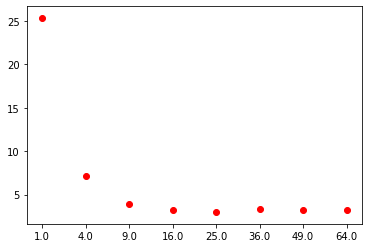

In [13]:
plt.errorbar(resumo_mpi['n_mpi_process'], resumo_mpi['mean_duration_clock'],
             yerr = 2*resumo_mpi['std_duration_clock'], fmt='ro')

Pode-se observar que os tempos de execução diminuem consideravelmente com o aumento do número de processos utilizados. 
Observando o intervalo $[9, 64]$ do número de processos utilizados, podemos checar visualmente os intervalos de confiança estimados para a nossa amostra:

<ErrorbarContainer object of 3 artists>

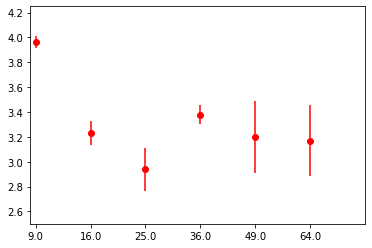

In [14]:
plt.xlim([1.9, 8])
plt.ylim([2.5, 4.25])
plt.errorbar(resumo_mpi['n_mpi_process'], resumo_mpi['mean_duration_clock'],
             yerr = 2*resumo_mpi['std_duration_clock'], fmt='ro')

Como podemos ver no gráfico acima, uma boa escolha de número de processos usados localmente na execução do programa é de $25$. Isso porque a média de tempo de execução é a mais baixa de todos para esse número de processos, além de que, se comparado a outros candidatos com baixo tempo de execução (49 e 64), o intervalo de confiança mostra-se o menor dentre os três, o que é uma vantagem, porque esperamos que futuros experimentos com este número de processos tenha uma maior "consistência" quanto ao tempo de execução. 

- Número de processos escolhido: 25


#### Análise CUDA
Para a versão CUDA, faremos um gráfico tridimensional, onde os eixos representam:
Eixo x: Raíz quadrada do número de threads executadas por bloco.
Eixo y: Raíz quadrada do número de blocos executados por grid.
Eixo z: Tempo de execução

Essas transformações foram feitas para a melhor visualização do gráfico, sem que precisemos escalar os eixos. 

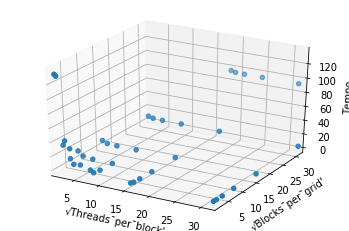

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x = resumo_cuda['x_block_cuda']
y = resumo_cuda['x_grid_cuda']
z = resumo_cuda['mean_duration_clock']

ax.set_xscale('linear')
ax.set_yscale('linear')

ax.set_xlim(1, 32)
ax.set_ylim(1, 32)

ax.set_xlabel('√Threads¯per¯block\'')
ax.set_ylabel('√Blocks¯per¯grid\'')
ax.set_zlabel('Tempo')

# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x,y) points are plotted on the x and z axes.

ax.scatter(x, y, zs=z, label='points in (x,z)')

Também plotamos o tempo de execução pela raíz quadrada do número de threads por bloco, agrupados pela raíz quadrada do número de blocos por grid:

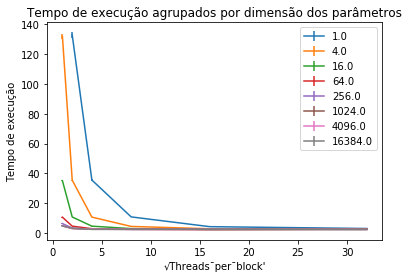

In [44]:
fig, ax = plt.subplots()

for key, group in resumo_cuda.groupby('x_grid_cuda'):
    group.plot('y_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key**2, ax=ax)   # 2

ax.set_xlabel('√Threads¯per¯block\'')
ax.set_ylabel('Tempo de execução')

plt.title('Tempo de execução agrupados pelo número de blocos por grid')

plt.show()

Como podemos ver, os melhores candidatos ao valor de tempo de execução do programa são os experimentos com grids $16\times16$, $32\times32$, $64\times64$ e $128\times128$. Além disso, vamos restringir um número mínimo de $2\times2$ threads por bloco.

Fazendo um gráfico, agora somente com esses experimentos:

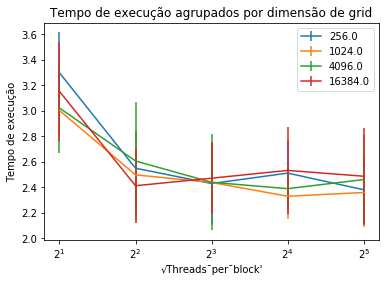

In [50]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.loc[23:][resumo_cuda.loc[23:].x_block_cuda > 1].groupby('x_grid_cuda'):
    group.plot('x_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key**2, ax=ax)   # 2

ax.set_xlabel('√Threads¯per¯block\'')
ax.set_ylabel('Tempo de execução')

plt.title('Tempo de execução agrupados pelo número de blocos por grid')

plt.show()

E novamente um gráfico para $32\times32$ e $64\times64$ blocos por grid:


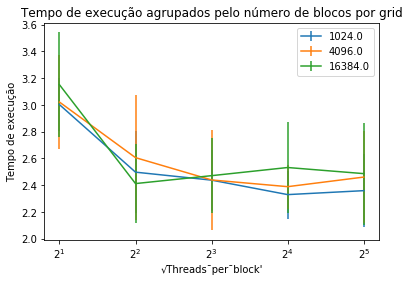

In [52]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.loc[29:][resumo_cuda.loc[29:].x_block_cuda > 1].groupby('x_grid_cuda'):
    group.plot('x_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key**2, ax=ax)   # 2
    
ax.set_xlabel('√Threads¯per¯block\'')
ax.set_ylabel('Tempo de execução')

plt.title('Tempo de execução agrupados pelo número de blocos por grid')

plt.show()

Separando os plots com os experimentos que possuem uma grid $32\times32$ e $128\times128$

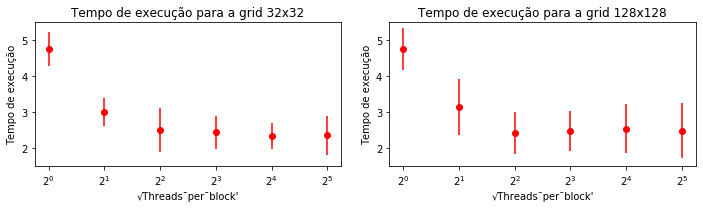

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax[0].set_xscale('log', basex=2)
ax[1].set_xscale('log', basex=2)

ax[0].set_ylim(1.5, 5.5)
ax[1].set_ylim(1.5, 5.5)

cuda_1 = resumo_cuda[resumo_cuda.x_grid_cuda == 32]
cuda_2 = resumo_cuda[resumo_cuda.x_grid_cuda == 128]

ax[0].errorbar(cuda_1['x_block_cuda'], cuda_1['mean_duration_clock'],
             yerr = 2*cuda_1['std_duration_clock'], fmt='ro')
ax[1].errorbar(cuda_2['x_block_cuda'], cuda_2['mean_duration_clock'],
             yerr = 2*cuda_2['std_duration_clock'], fmt='ro')

ax[0].set_xlabel('√Threads¯per¯block\'')
ax[0].set_ylabel('Tempo de execução')
ax[0].set_title('Tempo de execução para a grid 32x32')

ax[1].set_xlabel('√Threads¯per¯block\'')
ax[1].set_ylabel('Tempo de execução')
ax[1].set_title('Tempo de execução para a grid 128x128')



fig.tight_layout()

Podemos ver que há vários candidatos que possuem uma baixa média de tempo de execução, mas existe um destes que possui o menor intervalo de confiança dentre todos.

Desta forma, escolhemos como potencial conjunto de parâmetros para executar os experimentos:
- Dimensão dos blocos:  $(16, 16)$ 
- Dimensão da grid:  $(32, 32)$

### OpenMPI Vs. CUDA

Agora vamos comparar o tempo de execução entre os melhores candidatos da versão em MPI e da versão em CUDA, faznendo comentários a respeito de como um acelerador (GPU) pode impactar na velocidade de execução de um programa, assim como dos potenciais de cada implementação.

Para isso, vamos rodar um número maior do que 15 repetições (200 repetições) para cada um dos dois casos, o que pode demorar um tempo, e analisar com gráficos apropriados.

In [22]:
methods = ['mpi', 'cuda']
n_mpis = [25]
grids = [(32, 32)]
blocks = [(16, 16)]
repetitions = 200

# brute_bests = run_experiments(methods, n_mpis, grids, blocks, repetitions)

In [23]:
# brute_bests = pd.DataFrame(brute_bests)
# brute_bests.to_csv('testes_brutos_melhores.csv', index=False)

In [8]:
brute_bests = pd.read_csv('testes_brutos_melhores.csv')

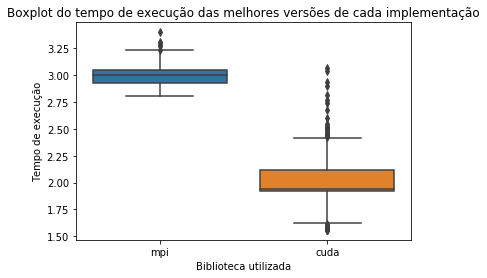

In [67]:
ax = seaborn.boxplot(x=brute_bests['method'], y=brute_bests['duration_clock'].astype('float'))
ax.set_xlabel('Biblioteca utilizada')
ax.set_ylabel('Tempo de execução')

title = plt.title('Boxplot do tempo de execução das melhores versões de cada implementação')

Como podemos ver no gráfico acima, o desempenho do algoritmo implementado em CUDA com auxílio de um acelerador é nitidamente superior se comparado aos resultados da implementação com OpenMPI.

## Conclusões e observações finais

### Resultados

Como pôde ser visto, não foi estritamente aumentando o número de threads ou processos rodando simultaneamente que o desempenho dos programas melhorou. O tempo de execução de um programa depende de inúmeros fatores, e no nosso caso, principalmente da latência com que as informações são trocadas, já que esse tipo de comunicação precisa ser estabelecida entre processos na versão OpenMPI, e entre o host e device na versão em CUDA. Apesar disso, conseguimos montar uma estratégia para selecionar e sugerir quais parâmetros podem ser satisfatórios para que o tempo de execução de um programa seja minimizado, dentro do possível, além de mostrarmos como a variação destes parâmetros impacta no tempo de execução dos mesmos. 

####  Potencial dos pacotes

Como visto anteriormente, nos experimentos realizados em uma mesma máquina, o desempenho da versão em CUDA foi nitidamente superior ao desempenho da versão implementada em MPI. Apesar disso, sabemos que o OpenMPI é feito com o intuito de utilizar processamento paralelo em mais de uma máquina, e até em mais de uma rede simultaneamente, coisa que não pudemos incluir nos experimentos devido à falta de disponibilidade de acesso a outras máquinas, seja na mesma rede, seja em outra.

É por este motivo que também sabemos que o desempenho em potencial da versão implementada em OpenMPI é praticamente ilimitada, e depende basicamente do número de computadores utilizados simultaneamente, do número de processos abertos em cada computador e também da velocidade de tráfego de informação entre os processos.

Também sabemos que a versão em CUDA pode oferecer um desempenho melhor ainda se utilizarmos GPUs mais poderosas ou modernas, ou até mais de uma GPU simultaneamente, coisa que poderia ser implementada até utilizando CUDA + OpenMPI. Na verdade, o ideal é que isso fosse feito, já que a máquina neozil da rede Linux oferece duas GPUs localmente. E o desempenho seria maior ainda se pudéssemos conectar várias máquinas com uma ou mais GPUs simultaneamnete.

### Infra Estrutura de trabalho remoto utilizando SSH

A realização deste trabalho demandou muito poder computacional. Como nenhum dos elementos da dupla possui uma máquina adequada para realizar os experimentos pedidos, precisamos aprender um pouco sobre o uso remoto da rede IME e da rede Linux. Como
nesse momento em que a grande maioria da comunidade IME não consegue estar fisicamente presente no instituto, resolvemos fazer
uma pequena descrição de como utilizamos a máquina neozin da rede Linux para realizar nossos experimentos.

Em primeiro lugar, gostaríamos de agradecer à comunidade, que 
mantém [esta página](https://wiki.ime.usp.br/) com diversas informações úteis, inclusive 
sobre o acesso remoto às redes do IME. Mais especificamente, 
[esta página](https://wiki.ime.usp.br/servicos:processamento) contém uma lista das máquinas do IME com grande poder computacional e orientações de como utilizá-las. Também gostaríamos de agradecer aos responsáveis pela manutenção [desta página](https://linux.ime.usp.br/wiki/doku.php?id=faq:cuda), que contém mais detalhes sobre a máquina neozil e sua utilização.

#### Abrindo uma porta para acesso local

Mesmo com a interface gráfica de um navegador de internet, ainda temos que lidar com algum tipo de delay, o que torna um tanto desconfortável editar um documento como este. Para resolver este problema, utilizamos o comando

``` ssh -NL [port]:localhost:[port] [seulogin]@brucutuiv.ime.usp.br```

para que possamos acessar o servidor oferecido pelo Jupyter localmente!